# Swift LDN dataset analysis

### **Starting up the Neo4j server (running on Debian 11)**


```sh
# Adding neo4j package repository (versions 4.4.*)
wget -O - https://debian.neo4j.com/neotechnology.gpg.key | sudo apt-key add -
echo 'deb https://debian.neo4j.com stable 4.4' | sudo tee /etc/apt/sources.list.d/neo4j.list
apt update
apt list -a neo4j

# Upgrading/installing Java and neo4j
apt upgrade
apt install openjdk-11-jdk
apt install neo4j

# Need to make few neo4j config changes:
#  + dbms.default_listen_address=0.0.0.0
#  + dbms.default_advertised_address=server-ip-address
systemctl stop neo4j
nano /etc/neo4j/neo4j.conf
systemctl start neo4j

# neo4j now can be accessed via: http://server-ip-address:7474

# Adding thesis databases to neo4j
# Downloaded from: https://zenodo.org/record/6641875

# From local machine:
scp C:\Users\Peter\Downloads\thesis\database.dump root@server-ip-address:~

# From server:
neo4j-admin load --from=database.dump --database=thesis
rm database.dump
# Can also make it as default database from the config
#  + dbms.default_database=thesis

# Might need to change folder permissions
chown -R neo4j:neo4j /var/lib/neo4j/data/databases/thesis
chown -R neo4j:neo4j /var/lib/neo4j/data/transactions/thesis



# Different systemctl commands
systemctl start neo4j
systemctl stop neo4j
systemctl restart neo4j
systemctl status neo4j
```



Before starting the anaysis, we made some modfications to the database. This will help to speed up our queries.


```
// Creating new relationship between two library nodes
MATCH (l:Library)<-[:IS]-(a:App)-[:CHANGED_TO]->(a2:App)-[:IS]->(l2:Library)
MERGE (l)-[:CHANGED_TO]->(l2);

// Adding indexes for faster lookup
CREATE INDEX app_timestamp_index IF NOT EXISTS FOR (a:App) ON (a.timestamp);
CREATE INDEX app_name_index IF NOT EXISTS FOR (a:App) ON (a.name);

CREATE INDEX library_name_index IF NOT EXISTS FOR (l:Library) ON (l.name);
CREATE INDEX library_version_index IF NOT EXISTS FOR (l:Library) ON (l.version);
```



### **Using neo4j python driver to access database**

There are two popular Python drivers for accessing neo4j databases:

*   [neo4j](https://pypi.org/project/neo4j/) - offical driver, looks to be constatnly updated
*   [py2neo](https://pypi.org/project/py2neo/) - community driver, more popular, with maybe easier usage, but isn't updated anymore (at least not so often). Last documented neo4j support is 4.3.

For the poruses of this thesis, I'm gonna use offical neo4j driver, because it has neo4j 4.4 support. Also it contains neo4j 5.* support, if I'm like to upgrade (e.g. asyncio features).

In [1]:
!pip install neo4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.5/187.5 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neo4j: filename=neo4j-5.8.0-py3-none-any.whl size=258407 sha256=aa4706ad14e8fa8aeab89cb023ffcb57133d747b093b02bfa1bcb6b25b863e90
  Stored in directory: /root/.cache/pip/wheels/6b/b5/da/73f634944e04e625954d101cb175ac1aeb9b29751a37d3383e
Successfully built neo4j


In [2]:
from neo4j import GraphDatabase
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import json

Environment variables that are later used for connecting to neo4j database. Those should be direct to neo4j server with thesis data as default database.

There is also a option to create a neo4j sandbox (https://sandbox.neo4j.com/), but free option only allows to create a database with 3 day trial period. After those 3 day, the database will be destroyed and you have to create a new sandbox. There also can be a problem with importing older version of neo4j database dump to the sandbox as sandbox hosts lastest version of neo4j 5, but thesis database requires neo4j versions 4.3 or 4.4.

In [3]:
class Neo4j:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()
                
    def read(self, query, *args):
      with self.driver.session() as session:
        return session.execute_read(query, *args)

    def write(self, query, *args):
      with self.driver.session() as session:
        return session.execute_write(query, *args)

In [4]:
uri = ''
user = ''
password = ''

In [5]:
neo4j = Neo4j(uri, user, password)

### Swift LDN statistics

We will check how many nodes are in the database.

In [6]:
def get_nodes_count(tx):
  records = tx.run("""
    MATCH (n)
    RETURN DISTINCT labels(n) as labels, COUNT(*) as count
    ORDER BY labels
  """)

  result = {}
  for r in records:
    result[r['labels'][0]] = r['count']

  return result

In [7]:
nodes_count = neo4j.read(get_nodes_count)

In [8]:
print('Nodes count:')
print(json.dumps(nodes_count, indent=2))

Nodes count:
{
  "App": 572131,
  "Library": 576144,
  "LibraryDefinition": 19390,
  "Project": 75550,
  "Vulnerability": 159
}


### Trends of upgrade/downgrades

#### Upgrade count

First we will plot a frequency of updates in libraries.

In [9]:
def get_updates(tx):
  record = tx.run("""
    MATCH (l:Library)<-[r:DEPENDS_ON]-(a:App)-[:CHANGED_TO]->(a2:App)
    OPTIONAL MATCH (a2)-[:DEPENDS_ON]->(l2:Library)
    WHERE (l)-[:CHANGED_TO*]->(l2) AND r.from_manifest IS NULL

    WITH a.name AS name, count(l2) AS update_count
    RETURN name, update_count
    ORDER BY update_count
  """)

  return [dict(r) for r in record]

In [10]:
updates_count_records = neo4j.read(get_updates)

In [11]:
df_upgrade_with_zeros = pd.DataFrame(updates_count_records)
df_upgrade = pd.DataFrame(list(filter(lambda x: x['update_count'] != 0, updates_count_records)))

upgrade_counts_with_zeros = df_upgrade_with_zeros["update_count"].value_counts()
upgrade_counts = df_upgrade["update_count"].value_counts()

In [12]:
upgrade_counts_with_zeros[:15]

0     3322
1      827
2      508
3      319
4      243
5      159
6      131
7      112
8       98
9       91
10      71
11      71
12      59
16      36
14      35
Name: update_count, dtype: int64

Data description with zero counts:

In [13]:
print("Total records count:", len(df_upgrade_with_zeros))
print(upgrade_counts_with_zeros.describe())

Total records count: 6602
count     121.000000
mean       54.561983
std       314.569836
min         1.000000
25%         1.000000
50%         2.000000
75%         9.000000
max      3322.000000
Name: update_count, dtype: float64


Data description without zero counts:

In [14]:
print("Total records count without zero:", len(df_upgrade), "\n")
print(f"Description:\n{upgrade_counts.describe()}", "\n")
print(upgrade_counts.quantile(0.9))

Total records count without zero: 3280 

Description:
count    120.000000
mean      27.333333
std       96.553319
min        1.000000
25%        1.000000
50%        2.000000
75%        8.250000
max      827.000000
Name: update_count, dtype: float64 

38.300000000000196


In [15]:
filtered_upgrade_counts = upgrade_counts_with_zeros[upgrade_counts_with_zeros > 38]

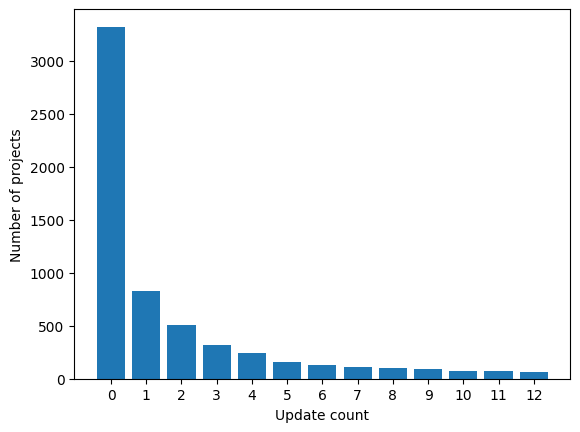

In [16]:
x = filtered_upgrade_counts.index
x_axis_values = np.arange(x.shape[0])
y = filtered_upgrade_counts.values

fig, ax = plt.subplots()

ax.bar(x_axis_values, y)

ax.set_xlabel('Update count')
ax.set_ylabel('Number of projects')

plt.xticks(x_axis_values, x)

plt.show()

#### Downgrade count

In [17]:
def get_downgrades(tx):
  record = tx.run("""
    MATCH (l:Library)<-[r:DEPENDS_ON]-(a:App)-[:CHANGED_TO]->(a2:App)
    OPTIONAL MATCH (a2)-[:DEPENDS_ON]->(l2:Library)
    WHERE (l)<-[:CHANGED_TO*]-(l2) AND r.from_manifest IS NULL

    WITH a.name AS name, count(l2) AS downgrade_count
    RETURN name, downgrade_count
    ORDER BY downgrade_count
  """)

  return [dict(r) for r in record]

In [82]:
downgrade_count_records = neo4j.read(get_downgrades)

Total count of apps from query:

In [19]:
df_downgrade_with_zeros = pd.DataFrame(downgrade_count_records)
df_downgrade = pd.DataFrame(list(filter(lambda x: x['downgrade_count'] != 0, downgrade_count_records)))

downgrade_counts_with_zeros = df_downgrade_with_zeros["downgrade_count"].value_counts()
downgrade_counts = df_downgrade["downgrade_count"].value_counts()

In [20]:
downgrade_counts_with_zeros[:15]

0     6117
1      180
2       74
3       44
4       25
6       24
7       15
5       12
9       10
13      10
11       7
27       7
8        6
23       6
10       5
Name: downgrade_count, dtype: int64

Data description with zero counts:

In [21]:
print("Total records count:", len(df_downgrade_with_zeros))
print(downgrade_counts_with_zeros.describe())

Total records count: 6602
count      43.000000
mean      153.534884
std       931.537371
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max      6117.000000
Name: downgrade_count, dtype: float64


Data description without zero counts:

In [22]:
print("Total records count without zero:", len(df_downgrade.tail(-1)), "\n")
print(f"Description:\n{downgrade_counts.tail(-1).describe()}", "\n")
print(downgrade_counts.tail(-1).quantile(0.8))

Total records count without zero: 484 

Description:
count    41.000000
mean      7.439024
std      13.488975
min       1.000000
25%       2.000000
50%       2.000000
75%       6.000000
max      74.000000
Name: downgrade_count, dtype: float64 

7.0


In [23]:
filtered_downgrade_counts = downgrade_counts_with_zeros[downgrade_counts_with_zeros > 10]

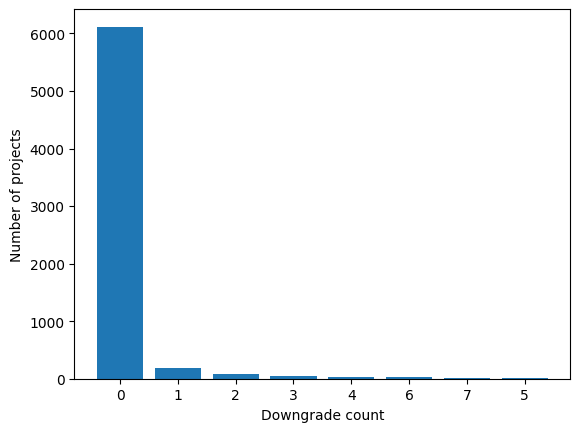

In [24]:
x = filtered_downgrade_counts.index
x_axis_values = np.arange(x.shape[0])
y = filtered_downgrade_counts.values

fig, ax = plt.subplots()

ax.bar(x_axis_values, y)

ax.set_xlabel('Downgrade count')
ax.set_ylabel('Number of projects')

plt.xticks(x_axis_values, x)

plt.show()

### Latest dependency count for libraries

In [25]:
def get_library_dependency_count(tx):
  record = tx.run("""
    MATCH (a:App)
    WITH a.name as name, a
    ORDER BY a.version_number
    WITH name, last(collect(a)) as latest

    MATCH (latest)-[:DEPENDS_ON]->(l:Library)
    WITH name, count(l) as libraries
    RETURN name, libraries
  """)

  return [dict(r) for r in record]

In [26]:
library_dependency_count_records = neo4j.read(get_library_dependency_count)

In [27]:
df_library_dependency_count = pd.DataFrame(library_dependency_count_records)

In [28]:
df_library_dependency_count.describe()

,libraries
count,6540.000000
mean,2.416514
std,2.388720
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,47.000000




### Most popular libraries that have dependencies

In [29]:
def get_most_popular_libraries(tx):
  record = tx.run("""
    MATCH (a:App)-[r:DEPENDS_ON]->(l:Library)
    WITH l.name AS name, count(DISTINCT a.name) AS usages
    RETURN name, usages
    ORDER BY usages DESC
  """)

  return [dict(r) for r in record]

In [30]:
most_popular_library_records = neo4j.read(get_most_popular_libraries)

In [31]:
df_most_popular_libraries = pd.DataFrame(most_popular_library_records)

In [32]:
df_most_popular_libraries.head()

,name,usages
0,alamofire/alamofire,662
1,quick/nimble,578
2,afnetworking/afnetworking,545
3,reactivex/rxswift,524
4,quick/quick,510


In [33]:
df_most_popular_libraries.describe()

,usages
count,5070.000000
mean,4.160355
std,22.217786
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,662.000000


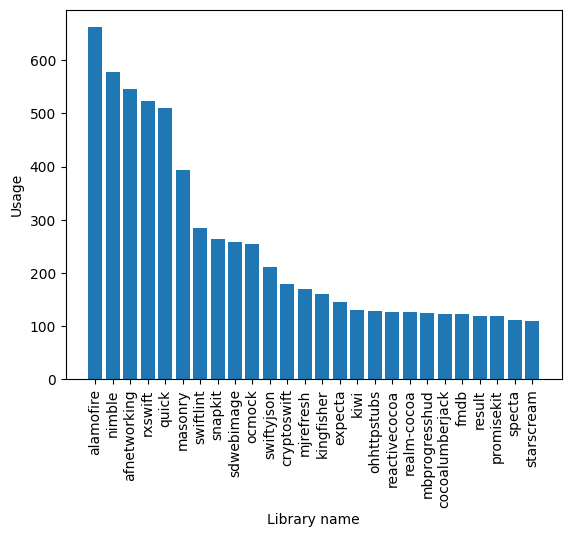

In [34]:
graph_values = df_most_popular_libraries[df_most_popular_libraries['usages'] > 100]

x = graph_values['name'].apply(lambda x: x[x.index('/')+1:])
y = graph_values['usages']

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_xlabel('Library name')
ax.set_ylabel('Usage')

plt.xticks(rotation=90)

plt.show()

In [35]:
graph_values

,name,usages
0,alamofire/alamofire,662
1,quick/nimble,578
2,afnetworking/afnetworking,545
3,reactivex/rxswift,524
4,quick/quick,510
5,cloudkite/masonry,393
6,realm/swiftlint,285
7,snapkit/snapkit,263
8,sdwebimage/sdwebimage,259
9,erikdoe/ocmock,254


### Most popular libraries that have vulnerabilities

In [36]:
def get_libraries_with_vulnerability(tx):
  record = tx.run("""
    MATCH (:Project)-[:HAS_APP]->(:App)-[:IS]->(l:Library)-[:HAS_VULNERABILITY]->(v)
    OPTIONAL MATCH (a:App)-[:DEPENDS_ON]->(l)
    WITH a, l, v
    ORDER BY l.version
    WITH l.name AS name, count(DISTINCT a.name) AS usages, count(DISTINCT v) AS vul_count, collect(DISTINCT l.version) AS vul_versions
    RETURN name, usages, vul_count, vul_versions
    ORDER BY usages DESC
  """)

  return [dict(r) for r in record]

In [37]:
libraries_with_vulnerability_records = neo4j.read(get_libraries_with_vulnerability)

In [38]:
df_libraries_with_vulnerability = pd.DataFrame(libraries_with_vulnerability_records)

In [39]:
df_libraries_with_vulnerability

,name,usages,vul_count,vul_versions
0,afnetworking/afnetworking,120,1,"[0.10.0, 0.10.1, 0.2.1, 0.3.0, 0.4.0, 0.5.0, 0..."
1,daltoniam/starscream,23,2,"[0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.9..."
2,apple/swift-nio-ssl,20,1,"[1.0.0, 1.0.1, 1.1.0, 1.1.1, 1.2.0, 1.2.1, 1.3..."
3,apple/swift-nio,12,9,"[1.0.0, 1.0.1, 1.1.0, 1.1.1, 1.2.0, 1.2.1, 1.2..."
4,grpc/grpc-swift,11,3,"[0.10.0, 0.4.2, 0.4.3, 0.5.1, 0.9.0, 0.9.1, 1...."
5,swisspol/gcdwebserver,10,1,"[1.0, 1.1, 1.2, 1.2.1, 1.2.2, 1.3, 1.4, 1.4.1,..."
6,apple/swift-nio-extras,7,1,"[0.1.0, 0.1.1, 0.1.2, 0.1.3, 1.0.0, 1.0.0-conv..."
7,ibm-swift/kitura,6,1,"[0.0.1, 0.0.12, 0.0.5, 0.0.6, 0.0.9, 0.10.0, 0..."
8,google/protobuf,3,2,"[conformance-build-tag, v2.4.1, v2.5.0, v2.6.0..."
9,vapor/vapor,2,3,"[3.3.0, 3.3.1, 4.7.0]"


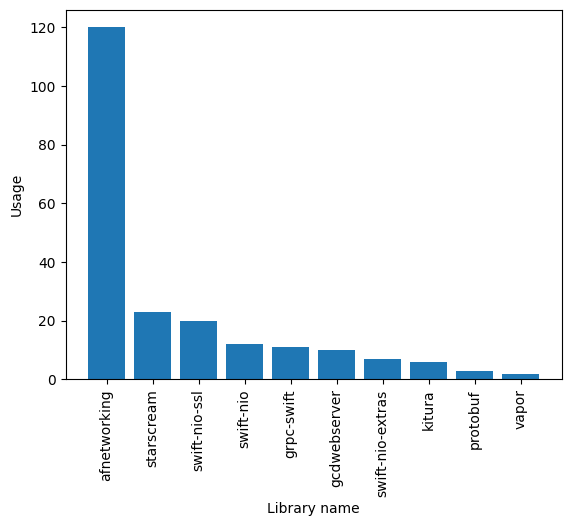

In [40]:
graph_usages = df_libraries_with_vulnerability[df_libraries_with_vulnerability['usages'] > 0]

x = graph_usages['name'].apply(lambda x: x[x.index('/')+1:])
y = graph_usages['usages']

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_xlabel('Library name')
ax.set_ylabel('Usage')

plt.xticks(rotation=90)

plt.show()

### Graphs about library all version usages

In [41]:
def get_library_usages(tx):
  record = tx.run("""
    MATCH (a:App)-[r:DEPENDS_ON]->(l:Library)<-[:IS]-(a2:App)
    WHERE r.from_manifest IS NULL
    WITH l.name AS name, l.version AS version, a2.version_number AS version_number, a2.time AS time, size(collect(DISTINCT a.name)) AS usages
    RETURN name, version, version_number, usages, time
    ORDER BY name, version_number
  """)

  return [dict(r) for r in record]

In [42]:
library_usages_records = neo4j.read(get_library_usages)

In [43]:
df_library_usages = pd.DataFrame(library_usages_records)

In [44]:
df_library_usages.head()

,name,version,version_number,usages,time
0,0x73/swifticonfont,2.7.0,22,1,Wed Jul 19 11:06:48 2017 +0300
1,0x73/swifticonfont,2.7.2,24,1,Wed Oct 11 21:30:05 2017 +0300
2,0x73/swifticonfont,2.7.3,25,1,Tue Dec 19 14:39:03 2017 +0300
3,0x73/swifticonfont,2.8.0,27,1,Fri May 18 00:53:49 2018 +0300
4,0x73/swifticonfont,3.0.0,30,1,Wed Nov 21 14:51:04 2018 +0300


In [45]:
def show_library_usages_chart(usages):
  x = usages['version']
  y = usages['usages']

  plt.figure(figsize=(12, 6))

  plt.bar(x, y)

  plt.xlabel('Library versions')
  plt.ylabel('Usages')

  plt.xticks(rotation=90)

  plt.show()

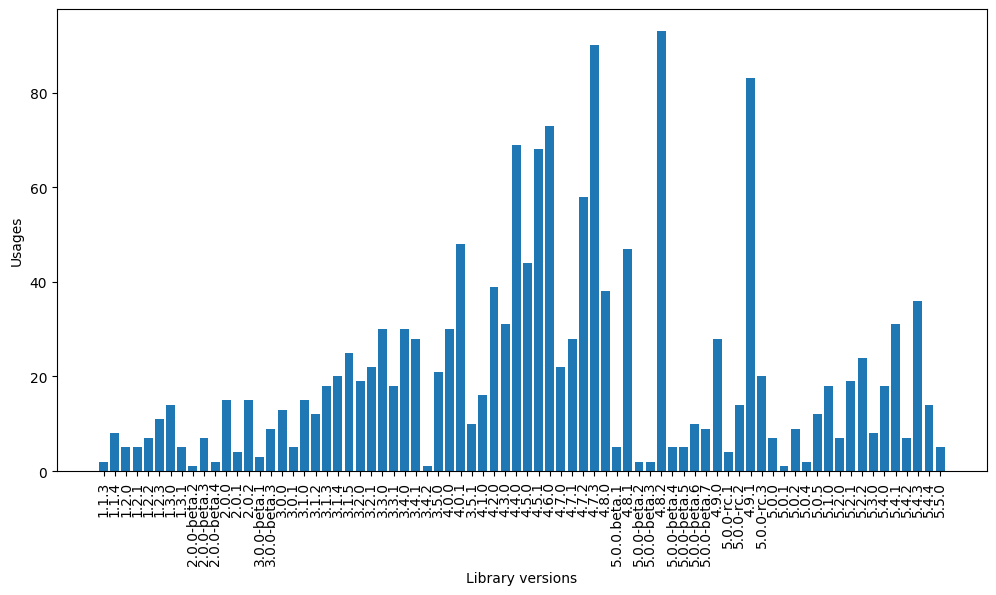

,name,version,version_number,usages,time
636,alamofire/alamofire,1.1.3,6,2,Fri Jan 9 11:12:23 2015 -0800
637,alamofire/alamofire,1.1.4,7,8,Fri Jan 30 09:36:14 2015 -0800
638,alamofire/alamofire,1.2.0,9,5,Thu Apr 9 08:34:49 2015 -0700
639,alamofire/alamofire,1.2.1,10,5,Tue Apr 21 08:36:26 2015 -0700
640,alamofire/alamofire,1.2.2,11,7,Wed May 13 11:50:42 2015 -0700
...,...,...,...,...,...
707,alamofire/alamofire,5.4.1,85,31,Sun Dec 20 21:16:04 2020 -0500
708,alamofire/alamofire,5.4.2,86,7,Sat Apr 3 17:45:03 2021 -0400
709,alamofire/alamofire,5.4.3,87,36,Wed Apr 21 22:49:02 2021 -0400
710,alamofire/alamofire,5.4.4,88,14,Mon Sep 20 19:46:54 2021 -0400


In [46]:
usages_subset = df_library_usages[df_library_usages.name == "alamofire/alamofire"]
show_library_usages_chart(usages_subset)
usages_subset

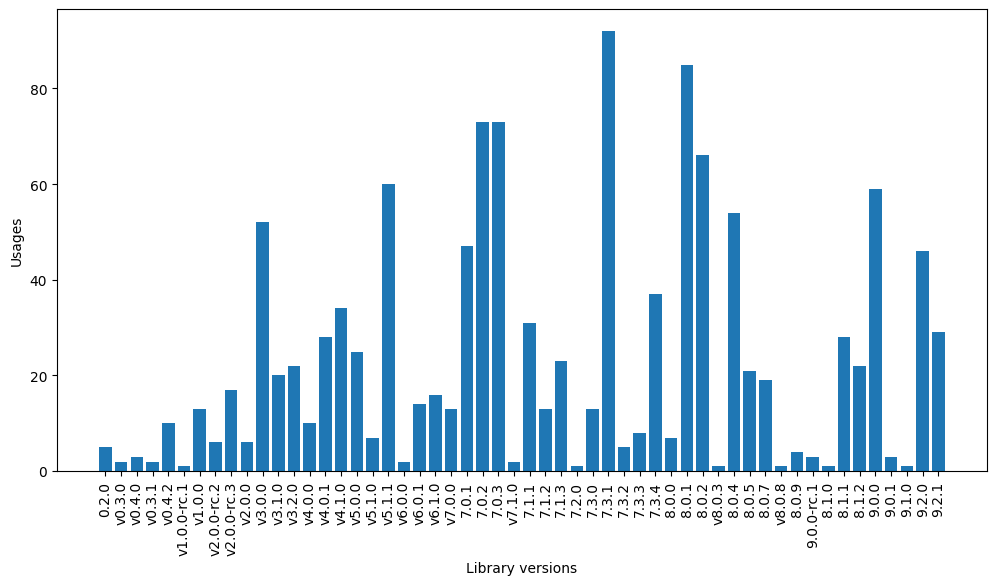

,name,version,version_number,usages,time
11004,quick/nimble,0.2.0,2,5,Wed Nov 26 12:32:57 2014 -0800
11005,quick/nimble,v0.3.0,3,2,Thu Jan 22 20:50:17 2015 -0800
11006,quick/nimble,v0.4.0,4,3,Tue Feb 10 21:13:56 2015 -0800
11007,quick/nimble,v0.3.1,5,2,Tue Mar 3 12:33:56 2015 -0800
11008,quick/nimble,v0.4.2,7,10,Sun Apr 5 22:41:35 2015 -0700
11009,quick/nimble,v1.0.0-rc.1,8,1,Sat May 16 12:42:52 2015 -0700
11010,quick/nimble,v1.0.0,10,13,Mon Jun 29 00:19:54 2015 -0700
11011,quick/nimble,v2.0.0-rc.2,11,6,Mon Jul 27 00:01:48 2015 -0700
11012,quick/nimble,v2.0.0-rc.3,12,17,Sun Aug 30 18:04:21 2015 -0700
11013,quick/nimble,v2.0.0,13,6,Mon Oct 5 01:17:43 2015 -0700


In [47]:
usages_subset = df_library_usages[df_library_usages.name == "quick/nimble"]
show_library_usages_chart(usages_subset)
usages_subset

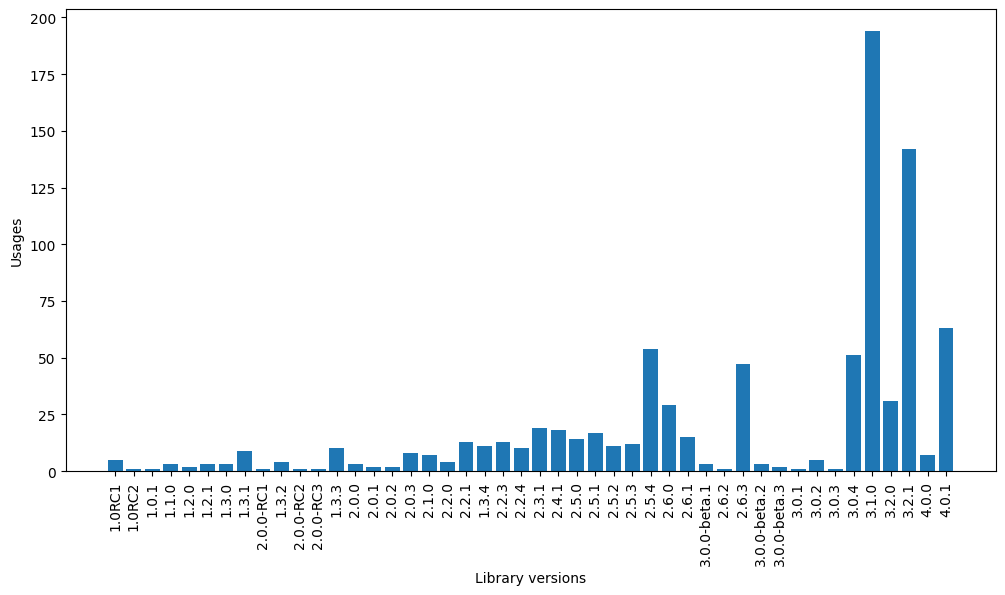

,name,version,version_number,usages,time
468,afnetworking/afnetworking,1.0RC1,13,5,Tue Apr 24 22:01:47 2012 -0700
469,afnetworking/afnetworking,1.0RC2,16,1,Fri Sep 14 10:59:18 2012 -0700
470,afnetworking/afnetworking,1.0.1,20,1,Thu Nov 1 08:56:17 2012 -0700
471,afnetworking/afnetworking,1.1.0,21,3,Thu Dec 27 17:01:06 2012 -0500
472,afnetworking/afnetworking,1.2.0,22,2,Sun Mar 24 02:22:50 2013 -0400
473,afnetworking/afnetworking,1.2.1,23,3,Thu Apr 18 07:47:53 2013 +0200
474,afnetworking/afnetworking,1.3.0,24,3,Sat Jun 1 17:51:23 2013 -0700
475,afnetworking/afnetworking,1.3.1,25,9,Tue Jun 18 09:44:52 2013 -0700
476,afnetworking/afnetworking,2.0.0-RC1,26,1,Fri Aug 2 16:57:58 2013 -0400
477,afnetworking/afnetworking,1.3.2,27,4,Thu Aug 8 15:39:11 2013 -0700


In [48]:
usages_subset = df_library_usages[df_library_usages.name == "afnetworking/afnetworking"]
show_library_usages_chart(usages_subset)
usages_subset

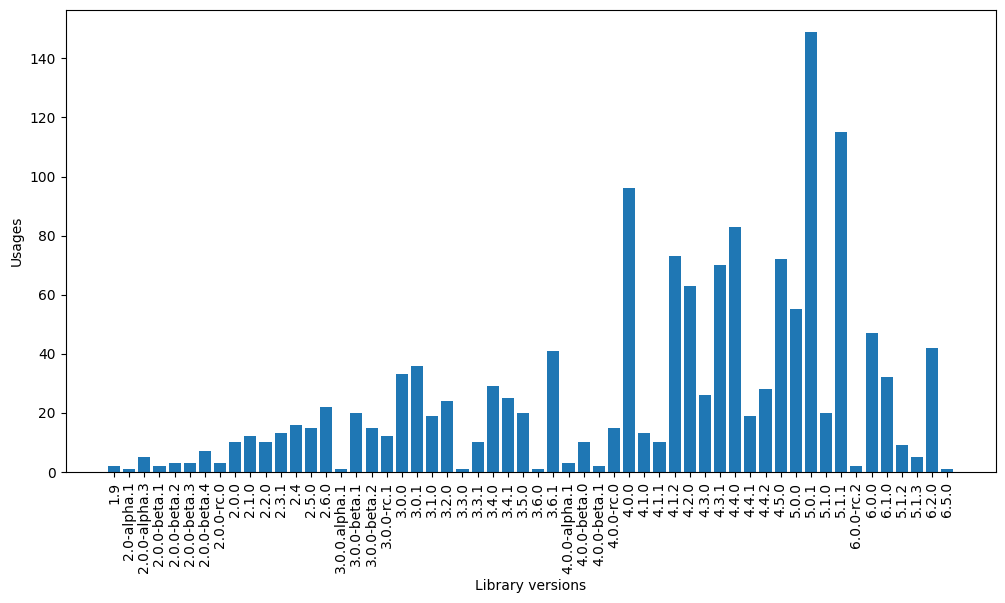

,name,version,version_number,usages,time
11404,reactivex/rxswift,1.9,17,2,Mon Aug 3 00:09:58 2015 +0200
11405,reactivex/rxswift,2.0-alpha.1,19,1,Tue Sep 1 13:55:52 2015 +0200
11406,reactivex/rxswift,2.0.0-alpha.3,21,5,Sun Sep 13 16:15:52 2015 +0200
11407,reactivex/rxswift,2.0.0-beta.1,23,2,Tue Oct 20 11:16:31 2015 +0200
11408,reactivex/rxswift,2.0.0-beta.2,24,3,Mon Nov 2 11:14:42 2015 +0100
11409,reactivex/rxswift,2.0.0-beta.3,25,3,Mon Nov 16 10:24:37 2015 +0100
11410,reactivex/rxswift,2.0.0-beta.4,26,7,Mon Dec 7 00:58:20 2015 +0100
11411,reactivex/rxswift,2.0.0-rc.0,27,3,Wed Dec 30 20:55:43 2015 +0100
11412,reactivex/rxswift,2.0.0,28,10,Sat Jan 2 00:36:33 2016 +0100
11413,reactivex/rxswift,2.1.0,29,12,Mon Jan 11 00:42:07 2016 +0100


In [49]:
usages_subset = df_library_usages[df_library_usages.name == "reactivex/rxswift"]
show_library_usages_chart(usages_subset)
usages_subset

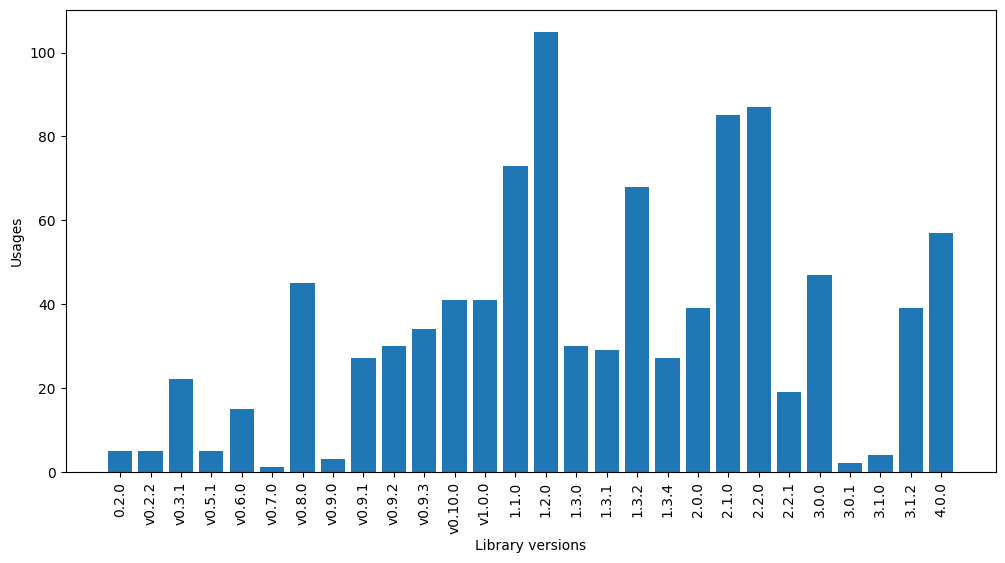

,name,version,version_number,usages,time
11058,quick/quick,0.2.0,2,5,Sun Nov 9 18:15:11 2014 -0800
11059,quick/quick,v0.2.2,4,5,Sat Dec 27 16:22:52 2014 -0500
11060,quick/quick,v0.3.1,7,22,Sun Apr 5 22:27:44 2015 -0700
11061,quick/quick,v0.5.1,10,5,Mon Jul 27 01:25:17 2015 -0700
11062,quick/quick,v0.6.0,11,15,Sun Aug 30 18:35:39 2015 -0700
11063,quick/quick,v0.7.0,12,1,Sun Oct 18 11:41:39 2015 -0700
11064,quick/quick,v0.8.0,13,45,Mon Oct 26 22:51:03 2015 -0700
11065,quick/quick,v0.9.0,14,3,Tue Jan 26 01:00:33 2016 -0500
11066,quick/quick,v0.9.1,15,27,Mon Feb 8 22:08:20 2016 -0500
11067,quick/quick,v0.9.2,16,30,Sat Apr 9 19:50:16 2016 -0600


In [50]:
usages_subset = df_library_usages[df_library_usages.name == "quick/quick"]
show_library_usages_chart(usages_subset)
usages_subset

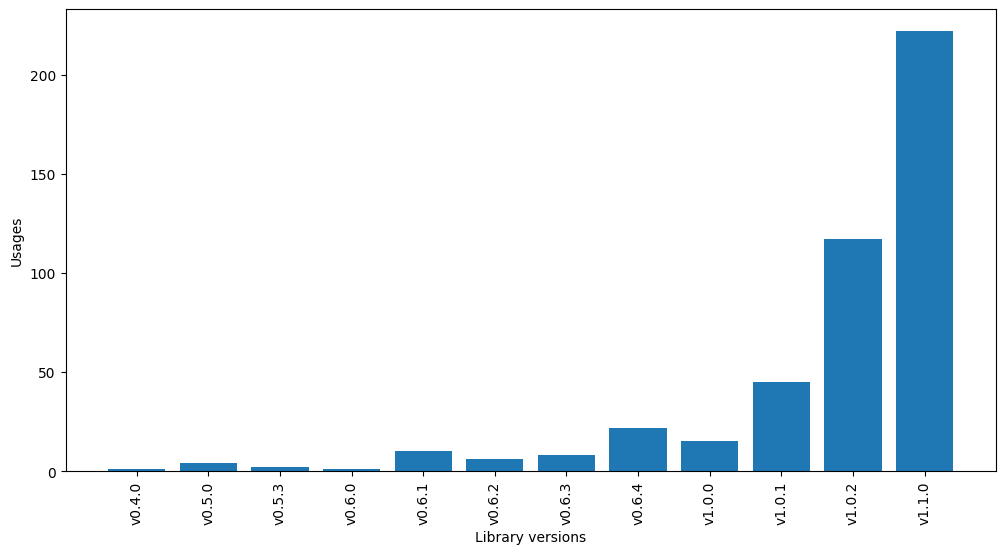

,name,version,version_number,usages,time
2696,cloudkite/masonry,v0.4.0,16,1,Mon Jan 20 20:53:52 2014 +0700
2697,cloudkite/masonry,v0.5.0,17,4,Tue May 13 10:14:17 2014 +1200
2698,cloudkite/masonry,v0.5.3,20,2,Fri Jul 25 07:47:19 2014 +1200
2699,cloudkite/masonry,v0.6.0,21,1,Fri Jan 9 09:14:49 2015 +1300
2700,cloudkite/masonry,v0.6.1,22,10,Tue Feb 3 14:15:40 2015 +1300
2701,cloudkite/masonry,v0.6.2,23,6,Mon Jul 6 14:21:08 2015 +1200
2702,cloudkite/masonry,v0.6.3,24,8,Tue Sep 22 22:44:43 2015 +1200
2703,cloudkite/masonry,v0.6.4,25,22,Wed Dec 23 04:47:49 2015 +1300
2704,cloudkite/masonry,v1.0.0,26,15,Thu Mar 31 21:26:36 2016 +1300
2705,cloudkite/masonry,v1.0.1,27,45,Sun May 29 23:14:23 2016 +1200


In [51]:
usages_subset = df_library_usages[df_library_usages.name == "cloudkite/masonry"]
show_library_usages_chart(usages_subset)
usages_subset

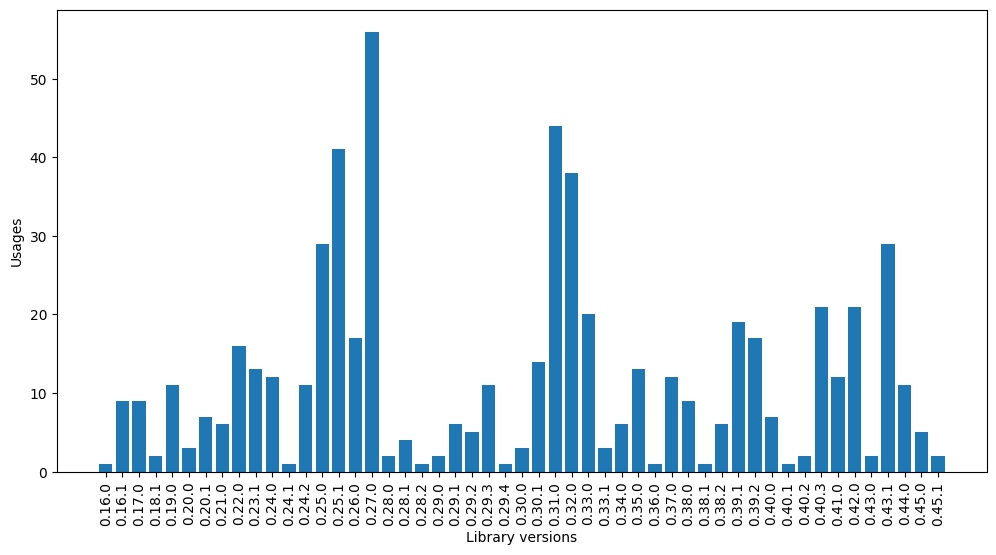

,name,version,version_number,usages,time
11635,realm/swiftlint,0.16.0,32,1,Tue Jan 10 17:05:13 2017 -0800
11636,realm/swiftlint,0.16.1,33,9,Fri Jan 20 10:32:03 2017 -0800
11637,realm/swiftlint,0.17.0,34,9,Thu Mar 23 22:32:37 2017 +0100
11638,realm/swiftlint,0.18.1,36,2,Thu Apr 6 16:45:34 2017 -0700
11639,realm/swiftlint,0.19.0,38,11,Thu May 25 14:25:31 2017 -0700
11640,realm/swiftlint,0.20.0,39,3,Sun Jun 18 20:33:09 2017 +0200
11641,realm/swiftlint,0.20.1,40,7,Sat Jul 1 20:19:33 2017 +0200
11642,realm/swiftlint,0.21.0,41,6,Wed Aug 2 00:18:04 2017 +0200
11643,realm/swiftlint,0.22.0,42,16,Wed Aug 30 14:38:04 2017 -0300
11644,realm/swiftlint,0.23.1,44,13,Tue Oct 10 09:54:51 2017 -0700


In [52]:
usages_subset = df_library_usages[df_library_usages.name == "realm/swiftlint"]
show_library_usages_chart(usages_subset)
usages_subset

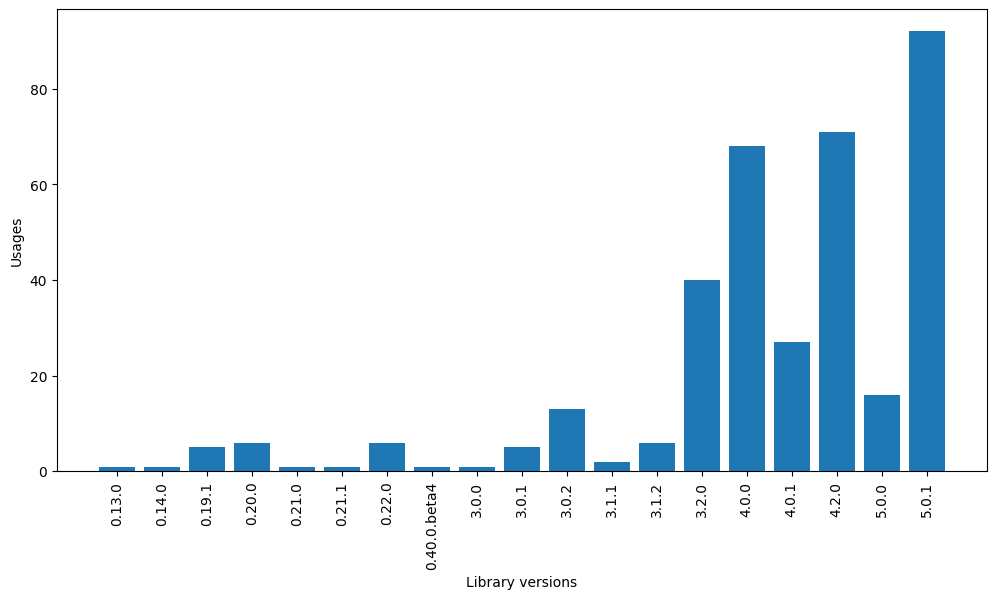

,name,version,version_number,usages,time
13298,snapkit/snapkit,0.13.0,13,1,Thu Jul 30 19:11:18 2015 +1200
13299,snapkit/snapkit,0.14.0,14,1,Sun Sep 13 01:09:22 2015 +1200
13300,snapkit/snapkit,0.19.1,19,5,Wed Jan 27 01:04:28 2016 +1300
13301,snapkit/snapkit,0.20.0,20,6,Fri Mar 25 16:29:10 2016 +1300
13302,snapkit/snapkit,0.21.0,21,1,Wed May 11 14:45:58 2016 +1200
13303,snapkit/snapkit,0.21.1,24,1,Tue Jun 21 19:11:24 2016 +1200
13304,snapkit/snapkit,0.22.0,27,6,Mon Aug 8 11:14:14 2016 +1200
13305,snapkit/snapkit,0.40.0.beta4,28,1,Fri Sep 2 00:57:40 2016 +1200
13306,snapkit/snapkit,3.0.0,29,1,Wed Sep 14 21:50:40 2016 +1200
13307,snapkit/snapkit,3.0.1,30,5,Tue Sep 20 17:18:13 2016 +1200


In [53]:
usages_subset = df_library_usages[df_library_usages.name == "snapkit/snapkit"]
show_library_usages_chart(usages_subset)
usages_subset

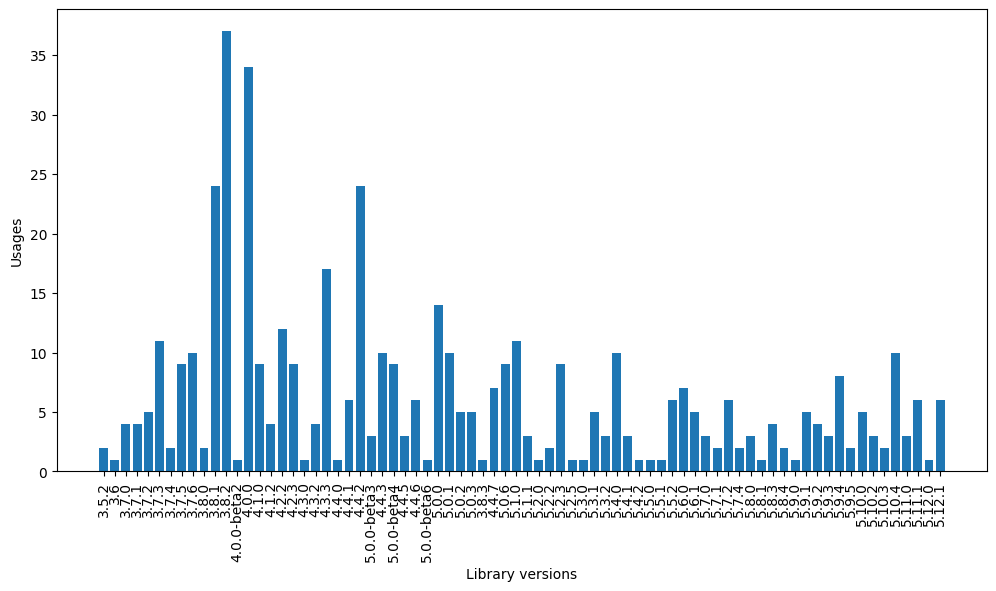

,name,version,version_number,usages,time
12898,sdwebimage/sdwebimage,3.5.2,21,2,Thu Jan 2 11:12:43 2014 -0800
12899,sdwebimage/sdwebimage,3.6,24,1,Mon Mar 24 13:32:45 2014 -0700
12900,sdwebimage/sdwebimage,3.7.0,25,4,Mon Jul 14 18:29:45 2014 +0300
12901,sdwebimage/sdwebimage,3.7.1,26,4,Wed Jul 23 08:17:14 2014 +0300
12902,sdwebimage/sdwebimage,3.7.2,27,5,Tue Mar 17 16:53:00 2015 +0200
...,...,...,...,...,...
12969,sdwebimage/sdwebimage,5.10.4,114,10,Tue Feb 2 17:56:01 2021 +0800
12970,sdwebimage/sdwebimage,5.11.0,115,3,Tue Apr 6 11:40:32 2021 +0800
12971,sdwebimage/sdwebimage,5.11.1,116,6,Fri Apr 23 20:33:53 2021 +0800
12972,sdwebimage/sdwebimage,5.12.0,117,1,Thu Sep 30 17:43:04 2021 +0800


In [54]:
usages_subset = df_library_usages[df_library_usages.name == "sdwebimage/sdwebimage"]
show_library_usages_chart(usages_subset)
usages_subset

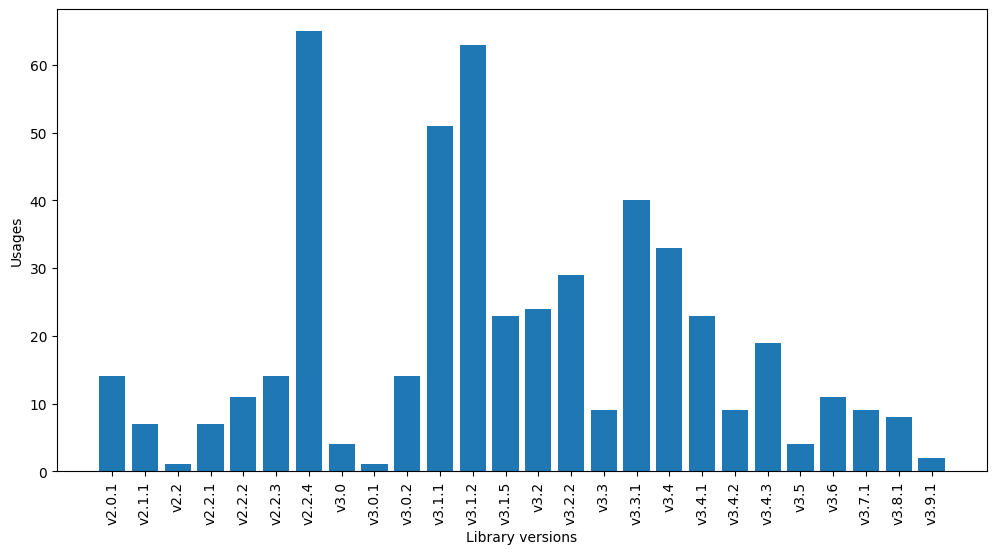

,name,version,version_number,usages,time
4325,erikdoe/ocmock,v2.0.1,3,14,Sat Mar 3 22:19:40 2012 -0600
4326,erikdoe/ocmock,v2.1.1,5,7,Sat Mar 16 00:23:26 2013 +0100
4327,erikdoe/ocmock,v2.2,7,1,Tue Jul 2 12:29:42 2013 +0200
4328,erikdoe/ocmock,v2.2.1,8,7,Wed Jul 24 16:25:14 2013 +0200
4329,erikdoe/ocmock,v2.2.2,9,11,Thu Dec 19 16:56:27 2013 +0100
4330,erikdoe/ocmock,v2.2.3,10,14,Mon Jan 6 22:17:04 2014 +0100
4331,erikdoe/ocmock,v2.2.4,11,65,Fri Apr 4 22:03:32 2014 +0200
4332,erikdoe/ocmock,v3.0,15,4,Thu Jun 12 12:19:29 2014 +0200
4333,erikdoe/ocmock,v3.0.1,16,1,Sun Jul 6 20:00:08 2014 +0100
4334,erikdoe/ocmock,v3.0.2,17,14,Mon Jul 7 15:59:07 2014 +0100


In [55]:
usages_subset = df_library_usages[df_library_usages.name == "erikdoe/ocmock"]
show_library_usages_chart(usages_subset)
usages_subset

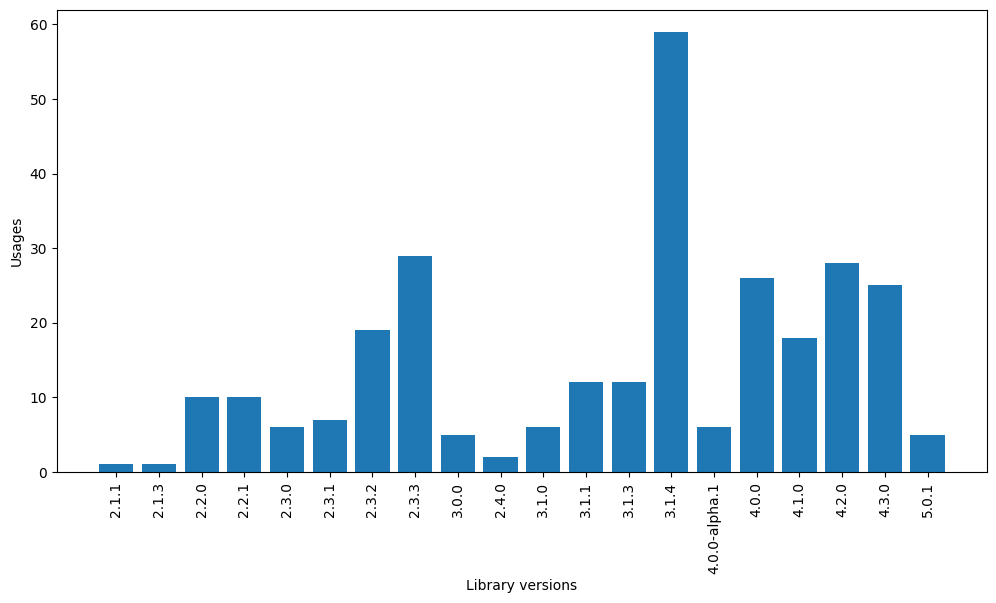

,name,version,version_number,usages,time
14061,swiftyjson/swiftyjson,2.1.1,5,1,Wed Nov 12 18:33:42 2014 +0800
14062,swiftyjson/swiftyjson,2.1.3,7,1,Sat Jan 10 15:04:29 2015 +0800
14063,swiftyjson/swiftyjson,2.2.0,8,10,Mon Apr 13 14:50:54 2015 +0800
14064,swiftyjson/swiftyjson,2.2.1,9,10,Wed Jul 29 00:56:02 2015 +0800
14065,swiftyjson/swiftyjson,2.3.0,10,6,Fri Sep 18 11:08:25 2015 +0800
14066,swiftyjson/swiftyjson,2.3.1,11,7,Mon Oct 26 17:28:34 2015 +0800
14067,swiftyjson/swiftyjson,2.3.2,12,19,Thu Dec 3 08:58:31 2015 +0800
14068,swiftyjson/swiftyjson,2.3.3,13,29,Fri Dec 4 21:33:51 2015 +0800
14069,swiftyjson/swiftyjson,3.0.0,14,5,Wed Sep 21 22:19:34 2016 +0800
14070,swiftyjson/swiftyjson,2.4.0,15,2,Wed Sep 21 22:55:35 2016 +0800


In [56]:
usages_subset = df_library_usages[df_library_usages.name == "swiftyjson/swiftyjson"]
show_library_usages_chart(usages_subset)
usages_subset

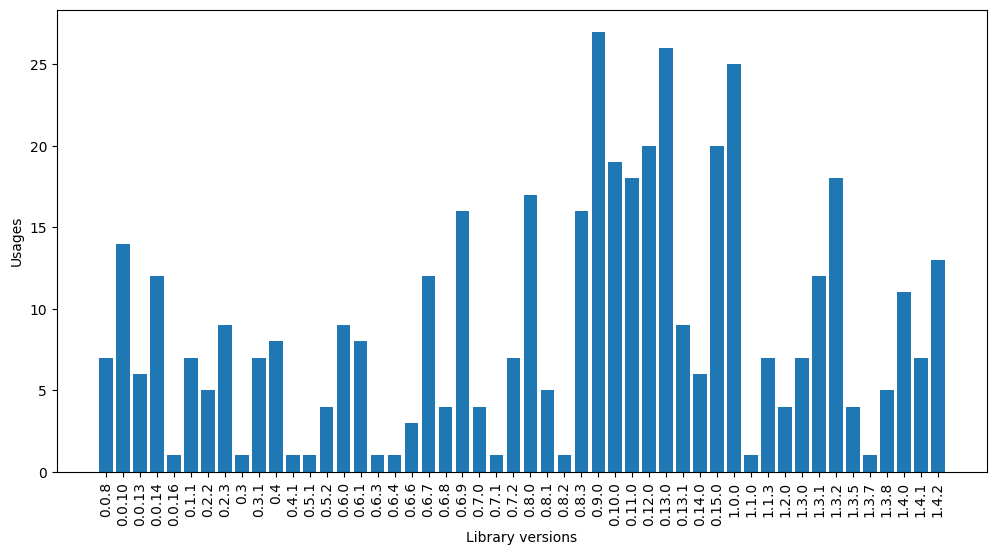

,name,version,version_number,usages,time
7437,krzyzanowskim/cryptoswift,0.0.8,8,7,Sat Feb 28 14:11:27 2015 +0100
7438,krzyzanowskim/cryptoswift,0.0.10,10,14,Mon Apr 13 15:50:56 2015 +0200
7439,krzyzanowskim/cryptoswift,0.0.13,13,6,Sat Aug 15 22:02:54 2015 +0200
7440,krzyzanowskim/cryptoswift,0.0.14,14,12,Mon Sep 14 23:46:03 2015 +0200
7441,krzyzanowskim/cryptoswift,0.0.16,16,1,Wed Sep 30 01:47:43 2015 +0200
7442,krzyzanowskim/cryptoswift,0.1.1,18,7,Wed Oct 14 08:40:59 2015 +0200
7443,krzyzanowskim/cryptoswift,0.2.2,21,5,Mon Dec 28 00:44:52 2015 +0100
7444,krzyzanowskim/cryptoswift,0.2.3,22,9,Thu Feb 11 10:14:09 2016 +0100
7445,krzyzanowskim/cryptoswift,0.3,23,1,Thu Mar 24 00:37:06 2016 +0100
7446,krzyzanowskim/cryptoswift,0.3.1,24,7,Thu Mar 31 02:26:09 2016 +0200


In [57]:
usages_subset = df_library_usages[df_library_usages.name == "krzyzanowskim/cryptoswift"]
show_library_usages_chart(usages_subset)
usages_subset

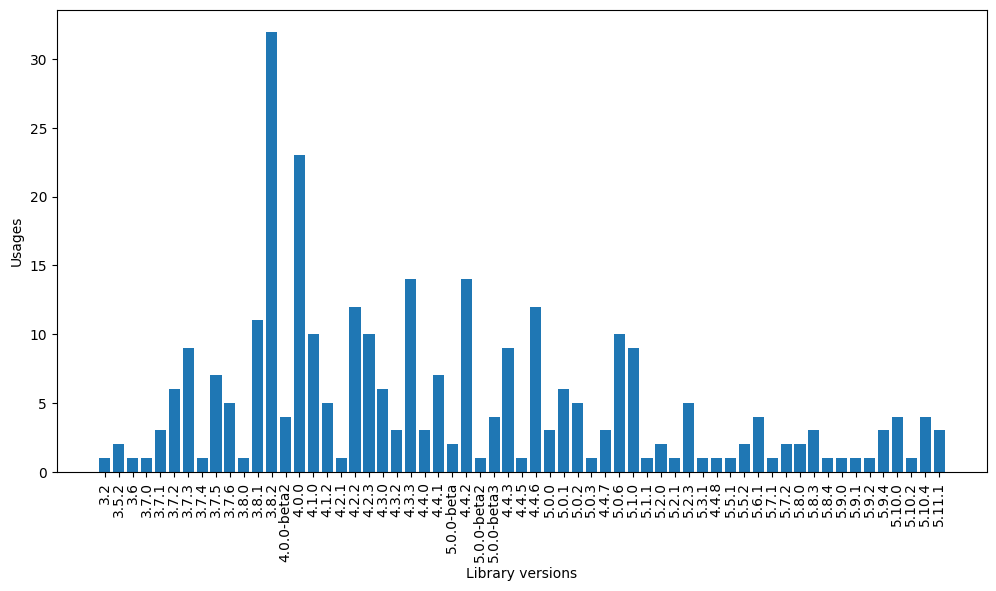

,name,version,version_number,usages,time
12076,rs/sdwebimage,3.2,16,1,Tue Mar 12 23:40:18 2013 +0100
12077,rs/sdwebimage,3.5.2,21,2,Thu Jan 2 11:12:43 2014 -0800
12078,rs/sdwebimage,3.6,24,1,Mon Mar 24 13:32:45 2014 -0700
12079,rs/sdwebimage,3.7.0,25,1,Mon Jul 14 18:29:45 2014 +0300
12080,rs/sdwebimage,3.7.1,26,3,Wed Jul 23 08:17:14 2014 +0300
...,...,...,...,...,...
12132,rs/sdwebimage,5.9.4,108,3,Fri Oct 23 10:36:09 2020 +0800
12133,rs/sdwebimage,5.10.0,110,4,Sun Nov 22 18:26:48 2020 +0800
12134,rs/sdwebimage,5.10.2,112,1,Tue Dec 29 11:41:01 2020 +0800
12135,rs/sdwebimage,5.10.4,114,4,Tue Feb 2 17:56:01 2021 +0800


In [58]:
usages_subset = df_library_usages[df_library_usages.name == "rs/sdwebimage"]
show_library_usages_chart(usages_subset)
usages_subset

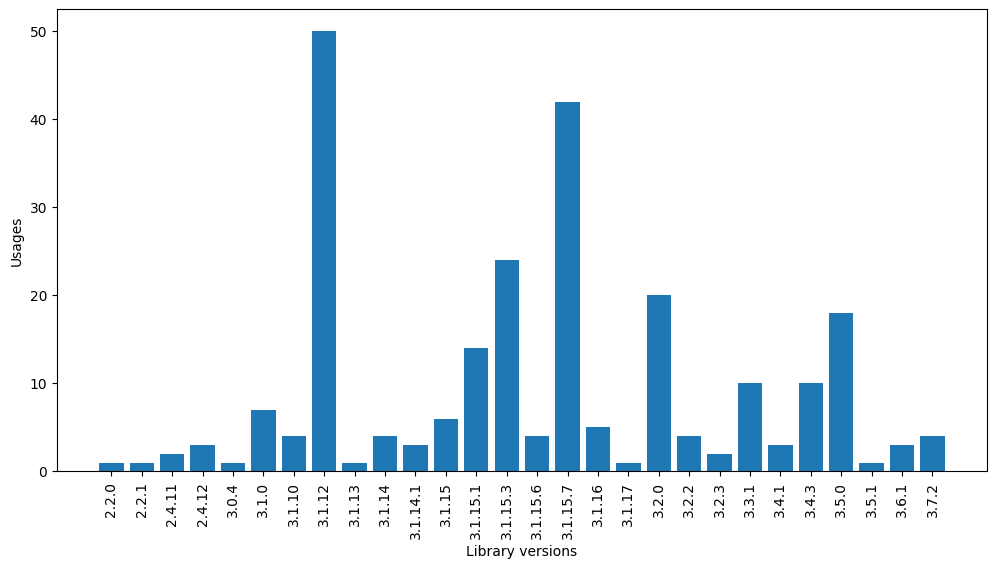

,name,version,version_number,usages,time
2794,codermjlee/mjrefresh,2.2.0,33,1,Thu Jul 2 13:05:23 2015 +0800
2795,codermjlee/mjrefresh,2.2.1,34,1,Tue Jul 14 13:04:04 2015 +0800
2796,codermjlee/mjrefresh,2.4.11,47,2,Wed Sep 23 12:34:52 2015 +0800
2797,codermjlee/mjrefresh,2.4.12,48,3,Sat Oct 10 12:08:48 2015 +0800
2798,codermjlee/mjrefresh,3.0.4,53,1,Wed Nov 18 17:31:10 2015 +0800
2799,codermjlee/mjrefresh,3.1.0,58,7,Mon Jun 13 21:35:10 2016 +0800
2800,codermjlee/mjrefresh,3.1.10,64,4,Wed Jul 6 15:15:11 2016 +0800
2801,codermjlee/mjrefresh,3.1.12,66,50,Sat Jul 23 16:37:26 2016 +0800
2802,codermjlee/mjrefresh,3.1.13,67,1,Wed Sep 27 17:23:47 2017 +0800
2803,codermjlee/mjrefresh,3.1.14,68,4,Thu Sep 28 16:10:23 2017 +0800


In [59]:
usages_subset = df_library_usages[df_library_usages.name == "codermjlee/mjrefresh"]
show_library_usages_chart(usages_subset)
usages_subset

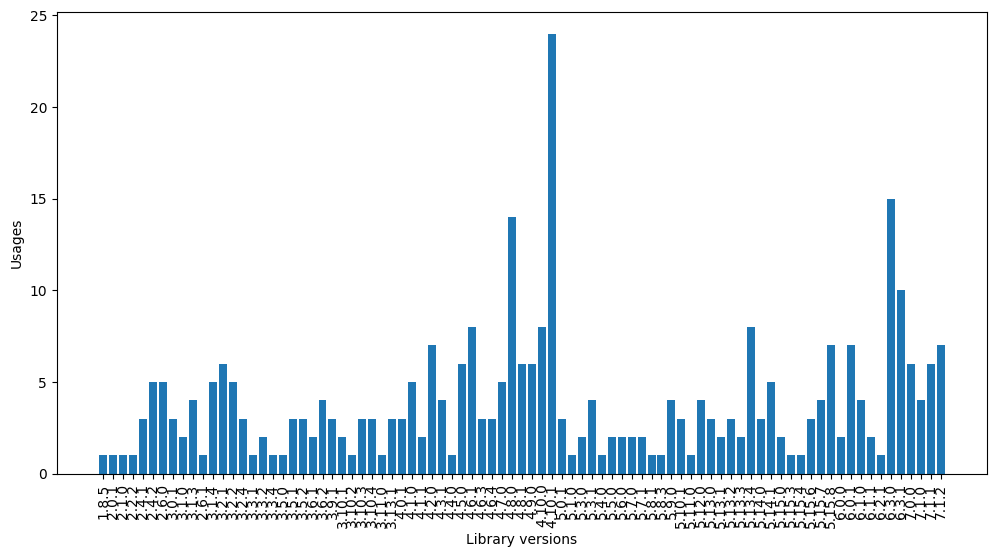

,name,version,version_number,usages,time
10373,onevcat/kingfisher,1.8.5,28,1,Wed Dec 16 11:52:38 2015 +0900
10374,onevcat/kingfisher,2.0.1,34,1,Thu Jan 28 16:49:39 2016 +0900
10375,onevcat/kingfisher,2.1.0,38,1,Thu Mar 10 23:26:31 2016 +0900
10376,onevcat/kingfisher,2.2.2,41,1,Wed Apr 6 23:25:07 2016 +0900
10377,onevcat/kingfisher,2.4.1,45,3,Tue May 10 14:07:11 2016 +0900
...,...,...,...,...,...
10453,onevcat/kingfisher,6.3.1,164,10,Tue Aug 3 10:04:43 2021 +0900
10454,onevcat/kingfisher,7.0.0,167,6,Tue Sep 21 21:54:23 2021 +0900
10455,onevcat/kingfisher,7.1.0,168,4,Tue Oct 12 01:07:06 2021 +0900
10456,onevcat/kingfisher,7.1.1,169,6,Sat Oct 16 01:08:09 2021 +0900


In [60]:
usages_subset = df_library_usages[df_library_usages.name == "onevcat/kingfisher"]
show_library_usages_chart(usages_subset)
usages_subset

### Library version usage trends over time 

In [6]:
def get_library_concrete_version_usages(tx, library, version, end_date=None):
  if (end_date is None):
    end_date = "2022-03-01"

  record = tx.run("""
    MATCH (a:App)-[:IS]->(l:Library {name: $library, version: $version})
    WITH l, date.truncate('month', datetime({epochSeconds:toInteger(a.timestamp)})) AS start_date, datetime($end_date) AS end_date
    WITH l, [month in range(0, duration.between(start_date, end_date).months) | start_date + duration({months: month})] AS dates
    UNWIND dates AS date
    WITH l, dateTime({year:date.year, month:date.month}) AS time

    MATCH (l)<-[r:DEPENDS_ON]-(a:App)
    WHERE toInteger(a.timestamp) < time.epochSeconds AND r.from_manifest is NULL
    OPTIONAL MATCH (a)-[:CHANGED_TO]->(a2:App)
    WHERE toInteger(a2.timestamp) < time.epochSeconds
    WITH date(time) AS date, a.name AS name, collect(a2 IS NOT null AND NOT exists((a2)-[:DEPENDS_ON]->(l))) AS uses_different_library
    RETURN date, count(
        CASE
        WHEN true IN uses_different_library THEN null
        ELSE name
        END
    ) AS count
  """, library=library, version=version, end_date=end_date)

  return [dict(r) for r in record]

## Alternative approach
#    MATCH (a:App)-[:IS]->(l:Library {name: $library, version: $version})
#    WITH l, datetime({epochSeconds:toInteger(a.timestamp)}) AS start_date, date($end_date) AS end_date
#    WITH l, [month in range(0, duration.between(start_date, end_date).months) | start_date + duration({months: month})] AS dates
#    UNWIND dates AS date
#    WITH l, dateTime({year:date.year, month:date.month}) AS time
#
#    MATCH (l)<-[:DEPENDS_ON]-(a:App)
#    WHERE toInteger(a.timestamp) < time.epochSeconds
#    OPTIONAL MATCH (a)-[:CHANGED_TO]->(a2:App)
#    WHERE toInteger(a2.timestamp) < time.epochSeconds
#    WITH l, a.name AS name, a2, time
#    ORDER BY toInteger(a2.timestamp)
#    WITH l, name, collect(a2) AS versions, time
#    WITH l, name, last(versions) AS last_version, time
#    WHERE (last_version)-[:DEPENDS_ON]->(l) OR last_version IS NULL
#
#    RETURN date(time) AS date, count(name) AS count
#    ORDER BY date

In [7]:
def show_library_concrete_version_usages_chart(library, versions, end_date=None, vulnerability_date=None, legends=True):
  usages = []

  for v in versions:
   record = neo4j.read(get_library_concrete_version_usages, library, v, end_date)
   
   if not record:
     continue
   
   usage = pd.DataFrame(record)
   usage['date'] = usage['date'].apply(lambda d: datetime.date(d.year, d.month, d.day))
   usages.append({"version": v, "usage": usage})

  fig, ax = plt.subplots(figsize=(12, 6))

  for usage in usages:
    x, y = usage['usage']['date'], usage['usage']['count']
    ax.plot(x, y, label=usage['version'])

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  ax.xaxis.set_major_locator(mdates.YearLocator())
  ax.xaxis.set_minor_locator(mdates.MonthLocator())

  if (vulnerability_date is not None):
    ymin, ymax = plt.gca().get_ylim()
    y_center = (ymin + ymax) / 2

    plt.axvline(vulnerability_date, color='gray', linestyle='--')
    plt.text(vulnerability_date, y_center,'vulnerability',rotation=90)

  if legends:
    plt.legend()

  plt.xlabel('Dates')
  plt.ylabel('Usages')

  plt.show()

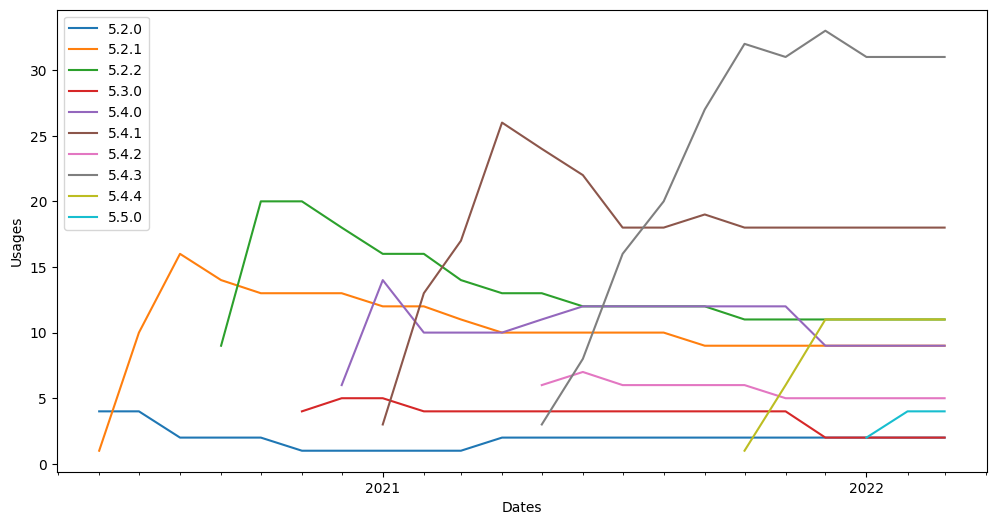

In [63]:
show_library_concrete_version_usages_chart("alamofire/alamofire", ["5.2.0","5.2.1","5.2.2","5.3.0","5.4.0","5.4.1","5.4.2","5.4.3","5.4.4","5.5.0"])

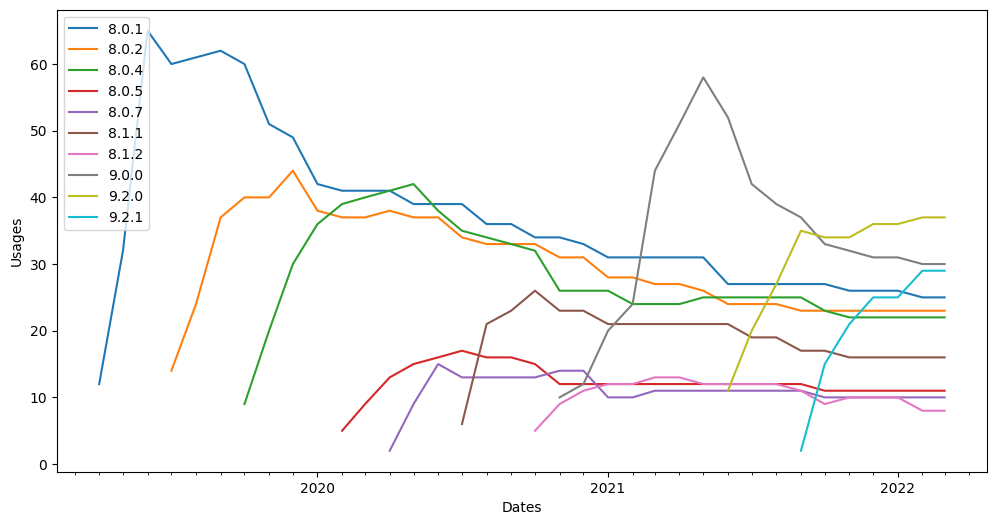

In [11]:
show_library_concrete_version_usages_chart("quick/nimble", ["8.0.1","8.0.2","8.0.4","8.0.5","8.0.7","8.1.1","8.1.2","9.0.0","9.2.0","9.2.1"])

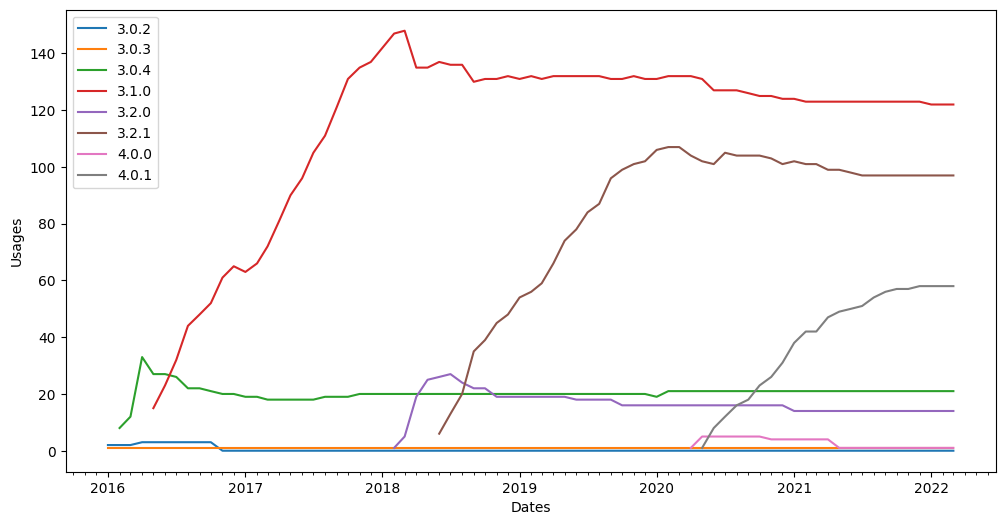

In [65]:
show_library_concrete_version_usages_chart("afnetworking/afnetworking", ["3.0.2","3.0.3","3.0.4","3.1.0", "3.2.0", "3.2.1", "4.0.0", "4.0.1"])

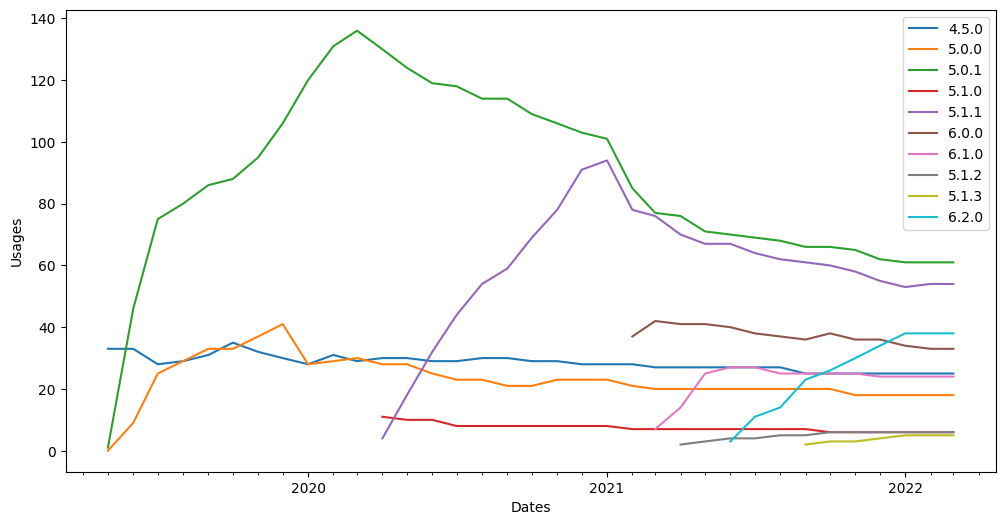

In [66]:
show_library_concrete_version_usages_chart("reactivex/rxswift", ["4.5.0","5.0.0","5.0.1","5.1.0","5.1.1","6.0.0","6.1.0","5.1.2","5.1.3","6.2.0"])

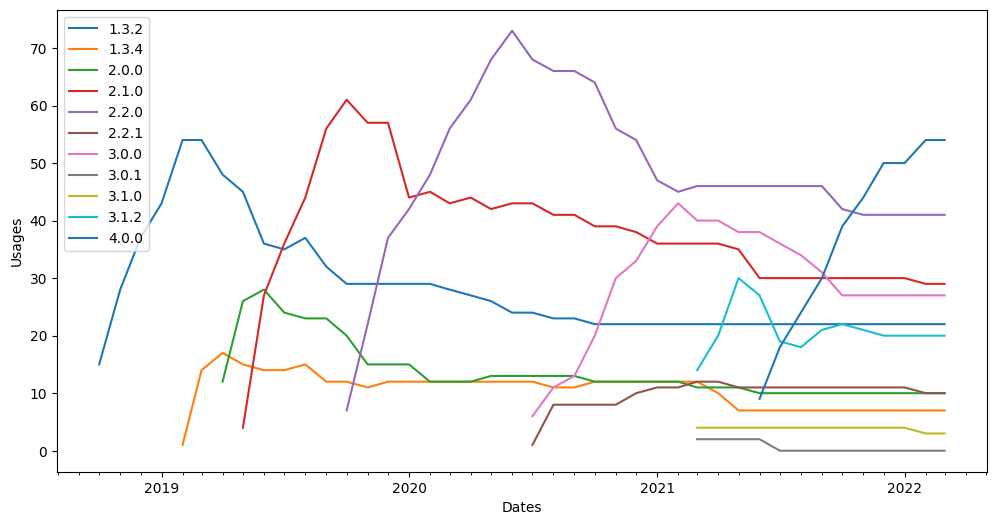

In [67]:
show_library_concrete_version_usages_chart("quick/quick", ["1.3.2","1.3.4","2.0.0","2.1.0","2.2.0","2.2.1","3.0.0","3.0.1","3.1.0","3.1.2","4.0.0"])

### Vulnerable library version usage trends over time

In [68]:
def get_all_libraries_with_vulnerability(tx):
  record = tx.run("""
    MATCH (:Project)-[:HAS_APP]->(:App)-[:IS]->(l:Library)-[:HAS_VULNERABILITY]->(v)
    OPTIONAL MATCH (a:App)-[:DEPENDS_ON]->(l)
    WITH a, l, v
    ORDER BY l.version
    WITH v.id AS id, l.name AS name, v.publishedDate AS date, count(DISTINCT a.name) AS usages, collect(DISTINCT l.version) AS vul_versions
    RETURN id, name, date, usages, vul_versions
    ORDER BY usages DESC, name, date
  """)

  return [dict(r) for r in record]

In [69]:
all_libraries_with_vulnerability_records = neo4j.read(get_all_libraries_with_vulnerability)

In [70]:
df_all_libraries_with_vulnerability = pd.DataFrame(all_libraries_with_vulnerability_records)

In [71]:
df_all_libraries_with_vulnerability.head()

,id,name,date,usages,vul_versions
0,CVE-2015-3996,afnetworking/afnetworking,2015-10-27T16:59Z,120,"[0.10.0, 0.10.1, 0.2.1, 0.3.0, 0.4.0, 0.5.0, 0..."
1,CVE-2017-5887,daltoniam/starscream,2017-04-06T14:59Z,23,"[0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.9..."
2,CVE-2017-7192,daltoniam/starscream,2017-04-06T14:59Z,23,"[0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.9..."
3,CVE-2019-8849,apple/swift-nio-ssl,2019-12-18T18:15Z,20,"[1.0.0, 1.0.1, 1.1.0, 1.1.1, 1.2.0, 1.2.1, 1.3..."
4,CVE-2018-4281,apple/swift-nio,2019-01-11T18:29Z,12,"[1.0.0, 1.0.1, 1.1.0, 1.1.1, 1.2.0, 1.2.1, 1.2..."


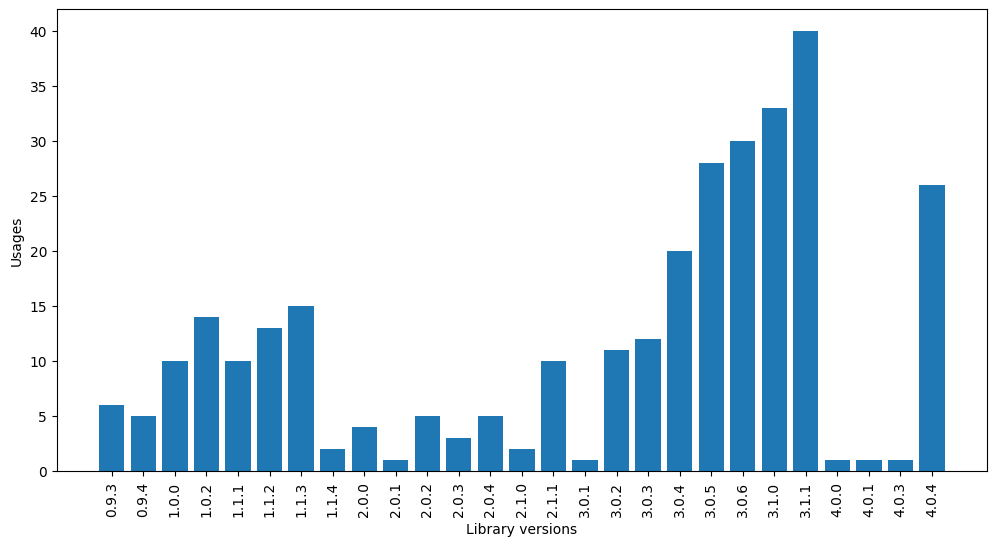

,name,version,version_number,usages,time
3080,daltoniam/starscream,0.9.3,3,6,Thu Apr 9 15:28:50 2015 -0700
3081,daltoniam/starscream,0.9.4,4,5,Tue Aug 4 10:34:45 2015 -0700
3082,daltoniam/starscream,1.0.0,8,10,Fri Sep 18 10:40:21 2015 -0700
3083,daltoniam/starscream,1.0.2,10,14,Thu Nov 5 10:09:45 2015 -0800
3084,daltoniam/starscream,1.1.1,12,10,Mon Jan 18 12:26:32 2016 -0800
3085,daltoniam/starscream,1.1.2,13,13,Mon Feb 8 19:04:10 2016 -0800
3086,daltoniam/starscream,1.1.3,14,15,Thu Mar 31 12:25:30 2016 -0700
3087,daltoniam/starscream,1.1.4,15,2,Sun Sep 18 16:18:21 2016 -0500
3088,daltoniam/starscream,2.0.0,16,4,Sun Sep 18 16:35:32 2016 -0500
3089,daltoniam/starscream,2.0.1,17,1,Wed Oct 26 20:41:30 2016 -0500


In [72]:
usages_subset = df_library_usages[df_library_usages.name == "daltoniam/starscream"]
show_library_usages_chart(usages_subset)
usages_subset

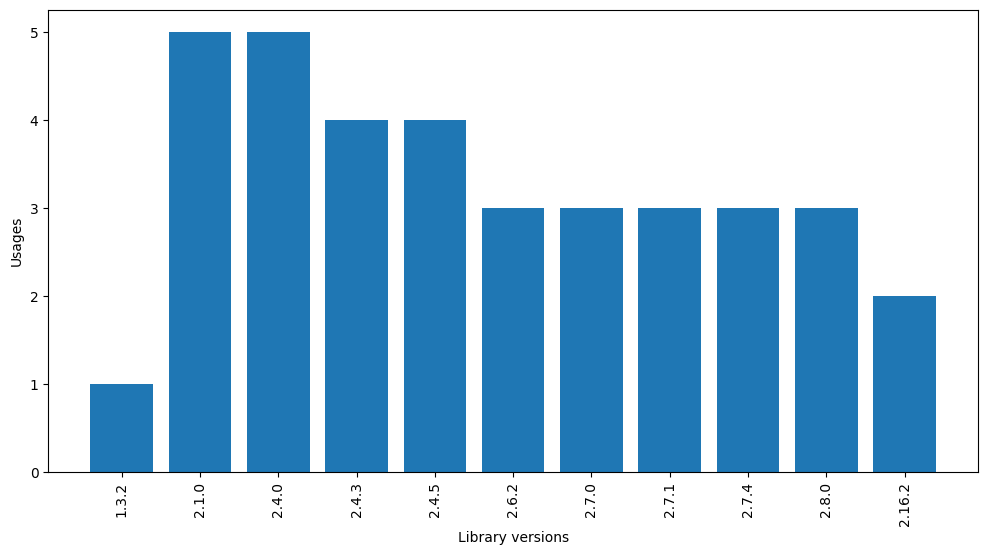

,name,version,version_number,usages,time
1193,apple/swift-nio-ssl,1.3.2,9,1,Fri Oct 5 16:08:21 2018 +0300
1194,apple/swift-nio-ssl,2.1.0,15,5,Wed May 22 16:41:33 2019 +0100
1195,apple/swift-nio-ssl,2.4.0,20,5,Mon Aug 12 16:42:17 2019 +0100
1196,apple/swift-nio-ssl,2.4.3,23,4,Wed Oct 23 17:24:01 2019 -0700
1197,apple/swift-nio-ssl,2.4.5,25,4,Wed Dec 4 17:06:24 2019 +0000
1198,apple/swift-nio-ssl,2.6.2,29,3,Fri Feb 14 12:37:30 2020 +0000
1199,apple/swift-nio-ssl,2.7.0,30,3,Mon Mar 23 16:26:05 2020 +0000
1200,apple/swift-nio-ssl,2.7.1,31,3,Thu Mar 26 15:04:20 2020 +0000
1201,apple/swift-nio-ssl,2.7.4,34,3,Thu Jun 4 20:39:42 2020 +0100
1202,apple/swift-nio-ssl,2.8.0,36,3,Tue Jun 30 15:16:01 2020 +0100


In [73]:
usages_subset = df_library_usages[df_library_usages.name == "apple/swift-nio-ssl"]
show_library_usages_chart(usages_subset)
usages_subset

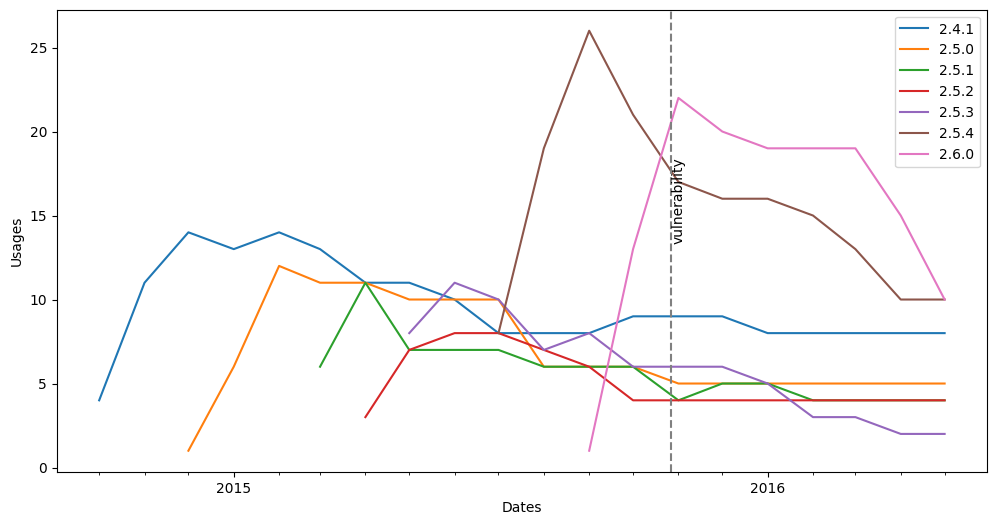

In [74]:
show_library_concrete_version_usages_chart("afnetworking/afnetworking", ["2.4.1", "2.5.0", "2.5.1", "2.5.2", "2.5.3", "2.5.4", "2.6.0"], "2016-05", datetime.datetime(2015, 10, 27))

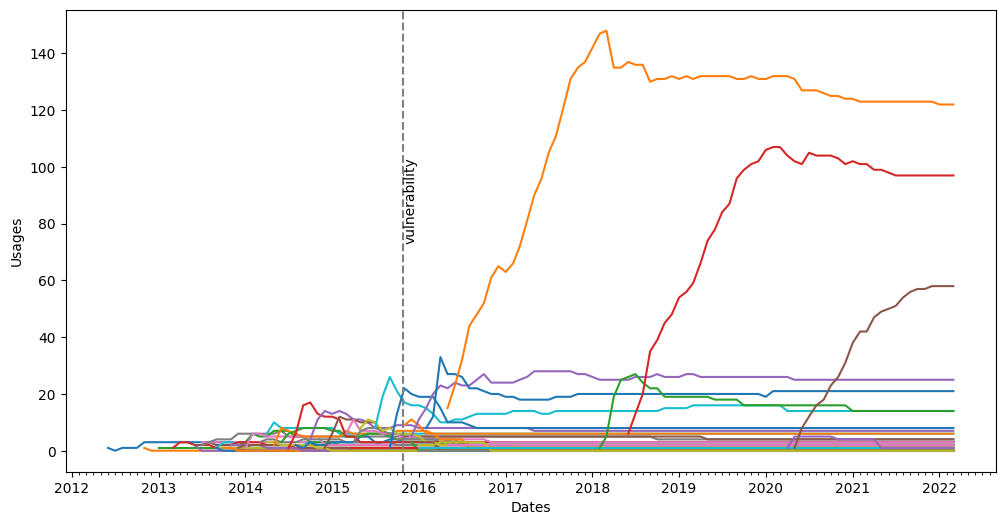

In [83]:
show_library_concrete_version_usages_chart("afnetworking/afnetworking", df_library_usages[df_library_usages.name == "afnetworking/afnetworking"]['version'], None, datetime.datetime(2015, 10, 27), False)

Comparing alamofire with afnetworking as they are similar libraries.

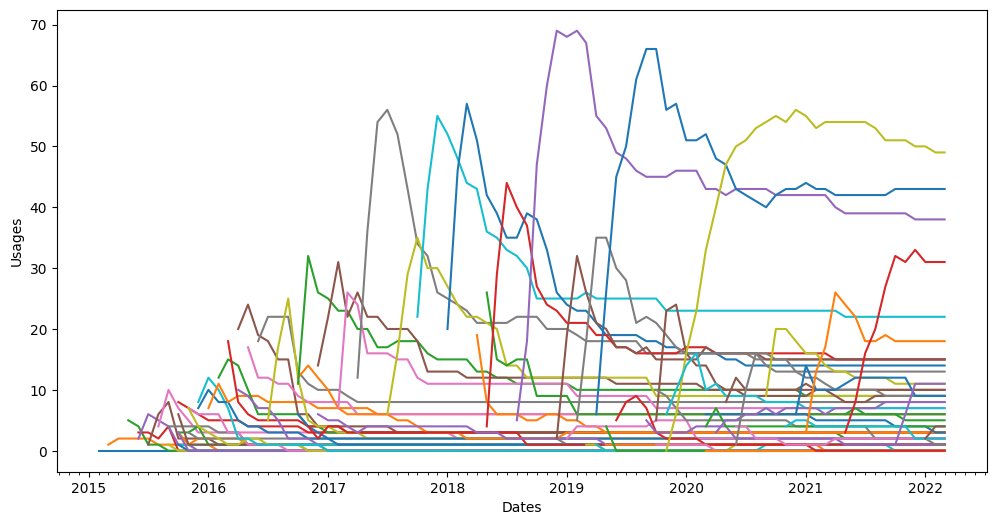

In [84]:
show_library_concrete_version_usages_chart("alamofire/alamofire", df_library_usages[df_library_usages.name == "alamofire/alamofire"]['version'], None, None, False)

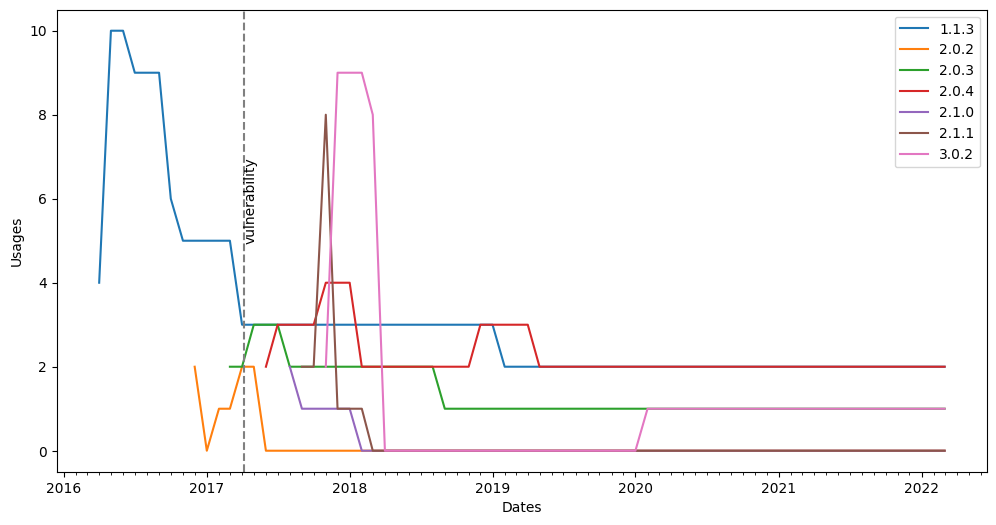

In [77]:
show_library_concrete_version_usages_chart("daltoniam/starscream", ["1.1.3","2.0.2","2.0.3","2.0.4","2.1.0","2.1.1", "3.0.2"], None, datetime.datetime(2017, 4, 6))

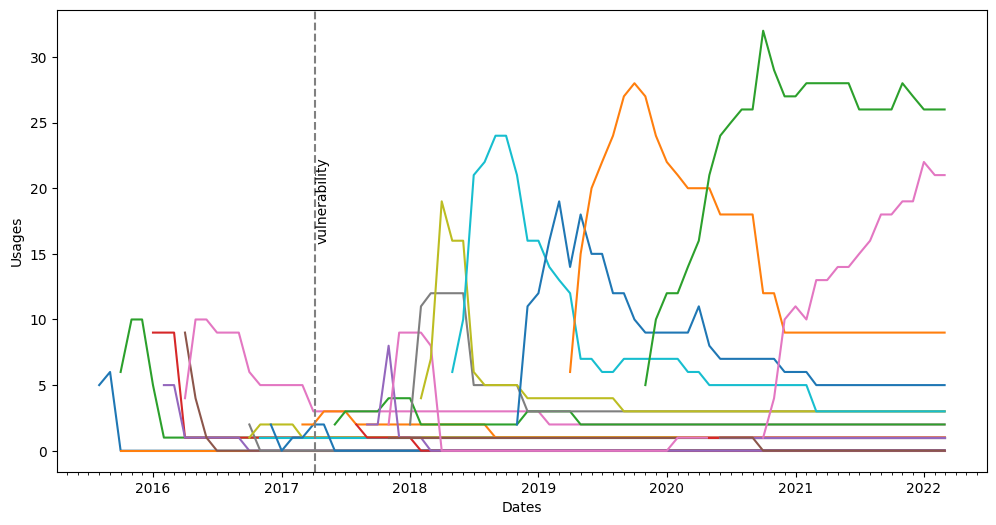

In [78]:
show_library_concrete_version_usages_chart("daltoniam/starscream", df_library_usages[df_library_usages.name == "daltoniam/starscream"]['version'], None, datetime.datetime(2017, 4, 6), False)

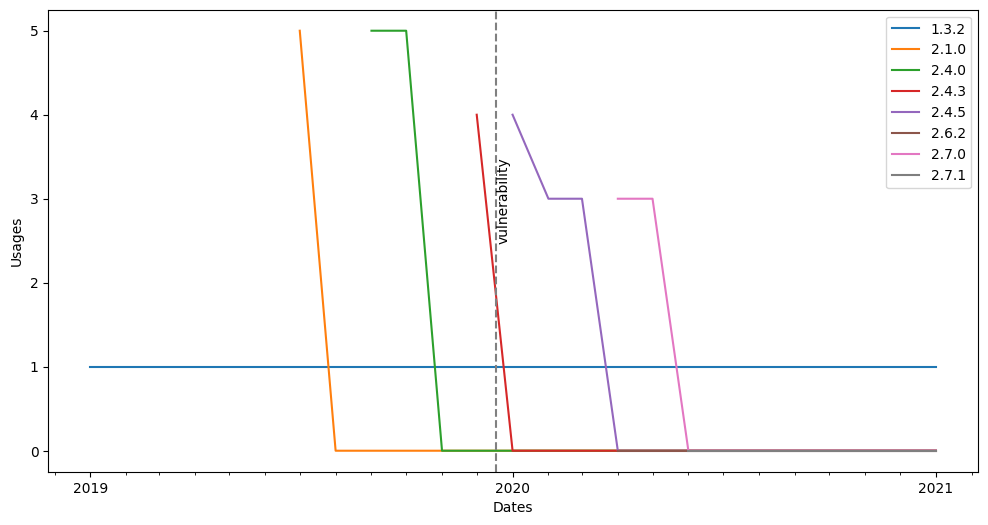

In [79]:
show_library_concrete_version_usages_chart("apple/swift-nio-ssl", ["1.3.2", "2.1.0","2.4.0","2.4.3","2.4.5","2.6.2","2.7.0","2.7.1"], "2021-01", datetime.datetime(2019, 12, 18))

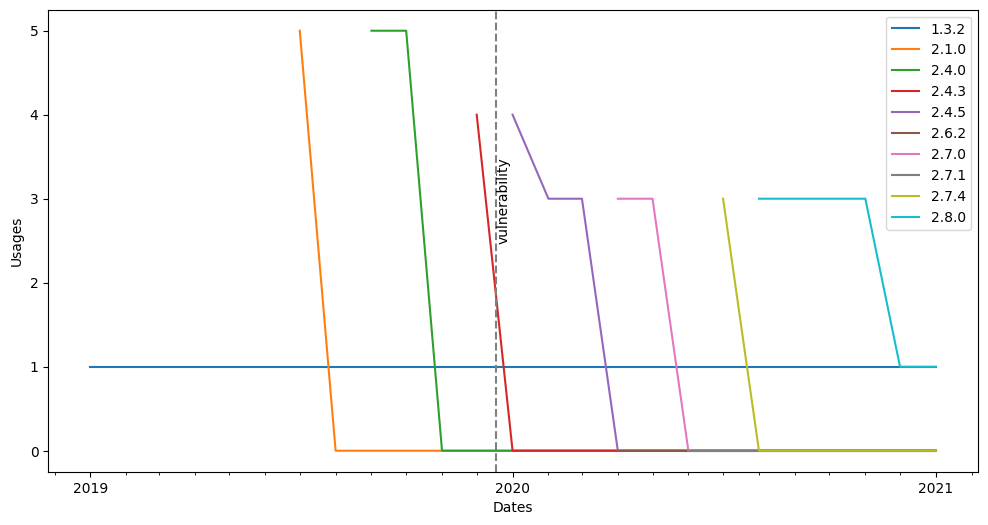

In [80]:
show_library_concrete_version_usages_chart("apple/swift-nio-ssl", df_library_usages[df_library_usages.name == "apple/swift-nio-ssl"]['version'], "2021-01", datetime.datetime(2019, 12, 18))

In [81]:
neo4j.close()